In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata
%matplotlib inline

In [2]:
trj1 = np.loadtxt('data/trj1.txt')
trj2 = np.loadtxt('data/trj2.txt')

* mass - kg
* coordinates - m
* potential energy - J

In [3]:
trj1 = trj1[:10000]
trj2 = trj2[:10000]

### a) Plot trajectory and color  by time step:

In [5]:
def plot_trajectory(traj):
    plt.figure(figsize=(9,7))
    plt.scatter(traj[:,0], traj[:,1], s=2, c=np.arange(len(traj[:,0])))
    plt.title('Positions colored by time step')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    plt.axis('equal')

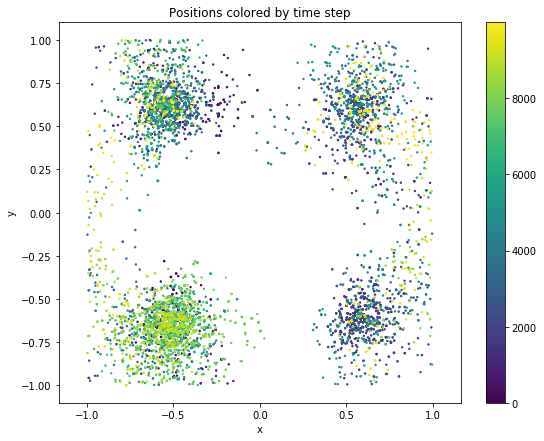

In [6]:
plot_trajectory(trj1)

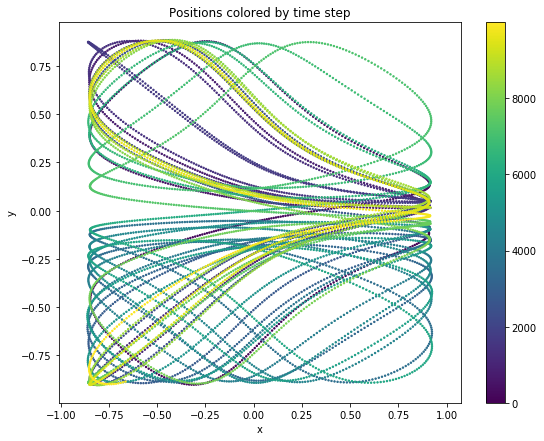

In [7]:
plot_trajectory(trj2)

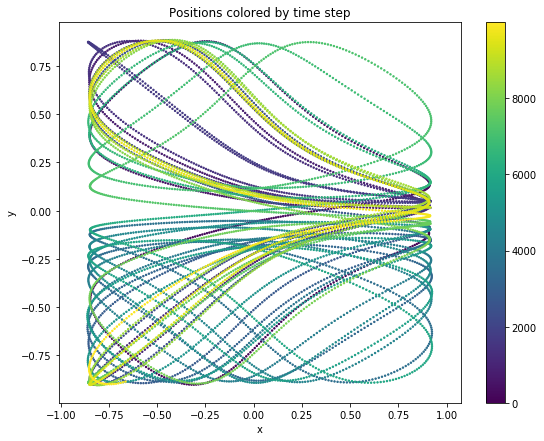

In [8]:
plot_trajectory(trj2[:50000])

### b) Discretize position and plot potential as function of position:

In [9]:
def plot_potential(traj):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Potential field')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('V(x, y)')

    dat = ax.scatter(traj[:,0], traj[:,1], traj[:,2], c=traj[:,2], cmap=cm.coolwarm)
    fig.colorbar(dat, orientation='horizontal')

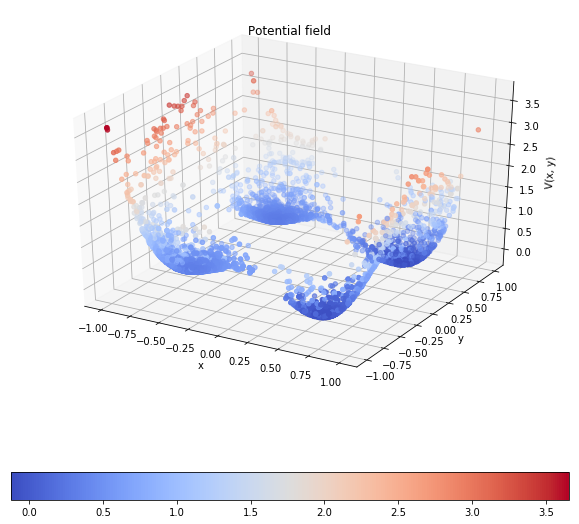

In [10]:
plot_potential(trj1)

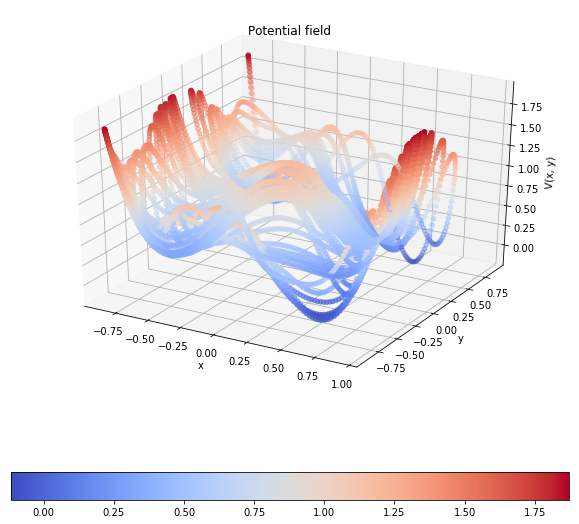

In [11]:
plot_potential(trj2)

In [12]:
def contour_potential(traj):
    plt.contour(traj[:,0], traj[:,1], traj[:,2])

TypeError: Input z must be a 2D array.

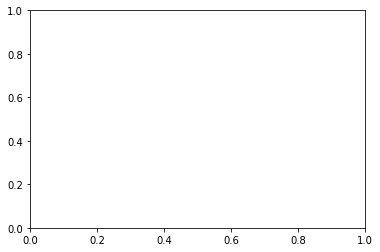

In [13]:
contour_potential(trj1[:100])

In [14]:
    ax[0].plot(traj[:,0], traj[:,1], '--', color='grey')
    ax[0].scatter(traj[:,0], traj[:,1], c=traj[:,0])
    ax[0].set_title('Positions colored by potential energy')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

NameError: name 'ax' is not defined

In [15]:
def position_histogram(traj):
    plt.figure(figsize=(7,7))
    plt.hist2d(traj[:,0], traj[:,1],  bins=100)
    plt.title('2D histogram of positions')
    plt.xlabel('x')
    plt.ylabel('y')

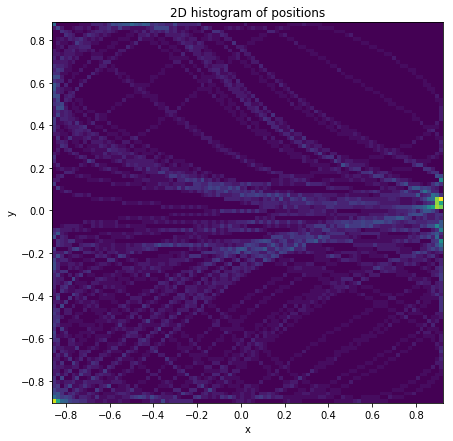

In [16]:
position_histogram(trj2[:10000])

TypeError: `bins` must be an integer, a string, or an array

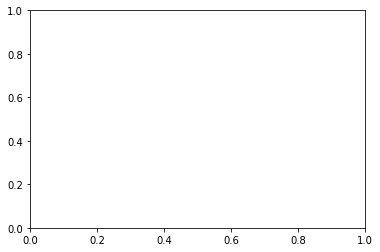

In [17]:
plt.hist(trj1[:,2], bins=0.1)

In [18]:
def discretize(data):
    for i in range(len(data)-1):
        print(data[i])

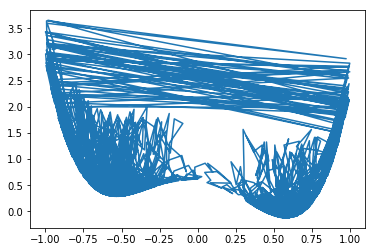

In [19]:
plt.plot(trj1[:10000][:,0], trj1[:10000][:,2])

In [33]:
def discretize_grid(traj):
    N = int(len(traj)*0.1)
    x = np.linspace(min(traj[:,0]),  max(traj[:,0]), N, endpoint=True)
    y = np.linspace(min(traj[:,1]),  max(traj[:,1]), N, endpoint=True)
    z = traj[:,2]
    X, Y = np.meshgrid(x, y)
#     print(X)
    zi = griddata((traj[:,0], traj[:,1]), z, (X, Y), method='cubic')
    
    print(zi)
#     fig = plt.figure()
#     ax = fig.gca(projection='3d')
#     ax.plot_surface(X, Y, zi, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

In [34]:
discretize_grid(trj1[:100])

[[       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [       nan 0.59440523 0.47894454 0.40276943 0.38016861 0.38695014
         nan        nan        nan        nan]
 [       nan 0.55307692 0.43579368 0.36213894 0.33687746 0.34262722
  0.37062983 0.41558108        nan        nan]
 [       nan 0.53656654 0.40630429 0.340176   0.31769819 0.32581434
  0.35270034 0.3989736  0.45370765        nan]
 [       nan 0.5505534  0.42527823 0.35723298 0.31888302 0.32881864
  0.35513306 0.3988702  0.45263456        nan]
 [       nan        nan 0.45294821 0.38592354 0.33749847 0.343758
  0.37084756 0.4152416  0.46834708        nan]
 [       nan        nan 0.45581131 0.39365884 0.379101   0.37657096
  0.40147918 0.44716749 0.4986743         nan]
 [       nan        nan 0.4524127  0.34780849 0.41086598 0.42683855
  0.44530036 0.48917541 0.54019148        nan]
 [       nan        nan        nan 0.4509496  0.44590966 0.46174954
  0.4927009  0

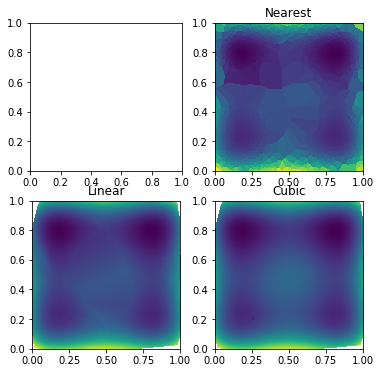

In [22]:
traj = trj1
N = int(len(traj)*0.1)
x = np.linspace(min(traj[:,0]),  max(traj[:,0]), N, endpoint=True)
y = np.linspace(min(traj[:,1]),  max(traj[:,1]), N, endpoint=True)
z = traj[:,2]
X, Y = np.meshgrid(x, y)
    
grid_z0 = griddata((traj[:,0], traj[:,1]), z, (X, Y), method='nearest')
grid_z1 = griddata((traj[:,0], traj[:,1]), z, (X, Y), method='linear')
grid_z2 = griddata((traj[:,0], traj[:,1]), z, (X, Y), method='cubic')

plt.subplot(221)
# plt.imshow(traj[:,2].T, extent=(0,1,0,1), origin='lower')
# plt.plot(traj[:,0], traj[:,1], 'k.', ms=1)
# plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic')
plt.gcf().set_size_inches(6, 6)